## Bi directional LSTM

In [26]:
import pandas as pd

train_df = pd.read_csv("../data/processed_data/basic_data/train.csv").drop(columns=["Unnamed: 0"], errors="ignore")
val_df   = pd.read_csv("../data/processed_data/basic_data/val.csv").drop(columns=["Unnamed: 0"], errors="ignore")
testA_df = pd.read_csv("../data/processed_data/basic_data/testA.csv").drop(columns=["Unnamed: 0"], errors="ignore")
testB_df = pd.read_csv("../data/processed_data/basic_data/testB.csv").drop(columns=["Unnamed: 0"], errors="ignore")




In [27]:
def build_vocab(urls):
    chars = set()
    for url in urls:
        chars.update(url)  # Adds unique characters to the set
    chars = sorted(list(chars))
    vocab = {c: i + 1 for i, c in enumerate(chars)}  # Assigns each character a unique integer ID
    vocab["<PAD>"] = 0  # Padding token to represent empty values
    return vocab

# Build vocab using URLs from the training set
all_urls = (
    train_df["url"].tolist()
    + val_df["url"].tolist()
    + testA_df["url"].tolist()
    + testB_df["url"].tolist()
)

vocab = build_vocab(all_urls)

# Print the vocab size and first few characters
print("Vocabulary size:", len(vocab))
print("Sample vocab:", list(vocab.items())[:10])
vocab

Vocabulary size: 284
Sample vocab: [('\x01', 1), ('\x02', 2), ('\x03', 3), ('\x04', 4), ('\x05', 5), ('\x06', 6), ('\x07', 7), ('\x08', 8), ('\t', 9), ('\n', 10)]


{'\x01': 1,
 '\x02': 2,
 '\x03': 3,
 '\x04': 4,
 '\x05': 5,
 '\x06': 6,
 '\x07': 7,
 '\x08': 8,
 '\t': 9,
 '\n': 10,
 '\x0b': 11,
 '\x0c': 12,
 '\r': 13,
 '\x0e': 14,
 '\x0f': 15,
 '\x10': 16,
 '\x11': 17,
 '\x12': 18,
 '\x13': 19,
 '\x14': 20,
 '\x15': 21,
 '\x16': 22,
 '\x17': 23,
 '\x18': 24,
 '\x19': 25,
 '\x1a': 26,
 '\x1b': 27,
 '\x1c': 28,
 '\x1d': 29,
 '\x1e': 30,
 '\x1f': 31,
 ' ': 32,
 '!': 33,
 '"': 34,
 '#': 35,
 '$': 36,
 '%': 37,
 '&': 38,
 "'": 39,
 '(': 40,
 ')': 41,
 '*': 42,
 '+': 43,
 ',': 44,
 '-': 45,
 '.': 46,
 '/': 47,
 '0': 48,
 '1': 49,
 '2': 50,
 '3': 51,
 '4': 52,
 '5': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57,
 ':': 58,
 ';': 59,
 '<': 60,
 '=': 61,
 '>': 62,
 '?': 63,
 '@': 64,
 'A': 65,
 'B': 66,
 'C': 67,
 'D': 68,
 'E': 69,
 'F': 70,
 'G': 71,
 'H': 72,
 'I': 73,
 'J': 74,
 'K': 75,
 'L': 76,
 'M': 77,
 'N': 78,
 'O': 79,
 'P': 80,
 'Q': 81,
 'R': 82,
 'S': 83,
 'T': 84,
 'U': 85,
 'V': 86,
 'W': 87,
 'X': 88,
 'Y': 89,
 'Z': 90,
 '[': 91,
 '\\': 92,
 

In [28]:
import torch
from torch.utils.data import Dataset

class URLDataset(Dataset):
    def __init__(self, urls, labels, vocab, max_len=200):
        self.urls = urls
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def encode_url(self, url):
        ids = [self.vocab.get(c, 0) for c in url]  # Map each character to its corresponding ID
        ids = ids[:self.max_len]  # Truncate URLs to max_len
        if len(ids) < self.max_len:
            ids += [0] * (self.max_len - len(ids))  # Pad to max_len if the URL is shorter
        return torch.tensor(ids, dtype=torch.long)

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = self.urls[idx]
        label = self.labels[idx]
        x = self.encode_url(url)
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [29]:
from torch.utils.data import DataLoader

import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

train_dataset = URLDataset(train_df["url"].tolist(), train_df["label"].tolist(), vocab)
val_dataset = URLDataset(val_df["url"].tolist(), val_df["label"].tolist(), vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


Using device: mps


In [30]:
import torch.nn as nn

class BiLSTM_URL_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, lstm_hidden=128, max_len=200):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0  # padding token index
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.pool = nn.AdaptiveMaxPool1d(1)  # Max-pooling layer

        self.fc = nn.Linear(lstm_hidden * 2, 1)  # Fully connected layer

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x, _ = self.lstm(x)    # (batch_size, seq_len, 2 * lstm_hidden)
        x = x.permute(0, 2, 1)  # (batch_size, 2 * lstm_hidden, seq_len)
        x = self.pool(x).squeeze(-1)  # (batch_size, 2 * lstm_hidden)
        x = self.fc(x)  # (batch_size, 1)
        return x  # raw logits (no sigmoid yet)


In [ ]:
class CNN_LSTM_URL_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, lstm_hidden=128, num_filters=128, kernel_size=5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.cnn = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

        self.lstm = nn.LSTM(
            input_size=num_filters,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(lstm_hidden * 2, 1)

    def forward(self, x):
        x = self.embedding(x)                # (B, L, E)
        x = x.permute(0, 2, 1)               # (B, E, L)

        x = self.cnn(x)                      # (B, C, L)
        x = x.permute(0, 2, 1)               # (B, L, C)

        x, _ = self.lstm(x)                  # (B, L, 2H)
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x


In [31]:
import torch.optim as optim

# Compute class weights based on training data
neg = train_df["label"].value_counts()[0]  # count of class 0
pos = train_df["label"].value_counts()[1]  # count of class 1

pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
print("pos_weight =", pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Initialize model
model = BiLSTM_URL_Model(
    vocab_size=len(vocab),
    embed_dim=32,
    lstm_hidden=128,
    max_len=200
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


pos_weight = tensor([1.], device='mps:0')


/Users/mohammedansari/Desktop/DeepPhishDetect/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [32]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    for urls, labels in loader:
        urls, labels = urls.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(urls).squeeze()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def eval_epoch(loader):
    model.eval()
    total_loss = 0
    correct = 0
    count = 0

    with torch.no_grad():
        for urls, labels in loader:
            urls, labels = urls.to(device), labels.to(device)
            logits = model(urls).squeeze()

            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == labels).sum().item()
            count += labels.size(0)

    return total_loss / len(loader), correct / count


In [33]:
for epoch in range(5):  # You can adjust the number of epochs
    train_loss = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


Epoch 1: train_loss=0.1689, val_loss=0.1010, val_acc=0.9651
Epoch 2: train_loss=0.0867, val_loss=0.1179, val_acc=0.9570
Epoch 3: train_loss=0.0659, val_loss=0.0617, val_acc=0.9797
Epoch 4: train_loss=0.0528, val_loss=0.0479, val_acc=0.9851
Epoch 5: train_loss=0.0422, val_loss=0.0438, val_acc=0.9858


In [34]:
testA_dataset = URLDataset(testA_df["url"].tolist(), testA_df["label"].tolist(), vocab)
testB_dataset = URLDataset(testB_df["url"].tolist(), testB_df["label"].tolist(), vocab)

testA_loader = DataLoader(testA_dataset, batch_size=64)
testB_loader = DataLoader(testB_dataset, batch_size=64)


In [35]:
import numpy as np

def evaluate_test(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for urls, labels in loader:
            urls, labels = urls.to(device), labels.to(device)

            logits = model(urls).squeeze()
            probs = torch.sigmoid(logits)

            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Test A
labelsA, predsA, probsA = evaluate_test(testA_loader)
print("\n=== Test A Classification Report ===")
print(classification_report(labelsA, predsA, digits=4))

# Test B
labelsB, predsB, probsB = evaluate_test(testB_loader)
print("\n=== Test B Classification Report ===")
print(classification_report(labelsB, predsB, digits=4))



=== Test A Classification Report ===
              precision    recall  f1-score   support

         0.0     0.9998    0.9838    0.9917     93820
         1.0     0.8604    0.9977    0.9239      9382

    accuracy                         0.9851    103202
   macro avg     0.9301    0.9907    0.9578    103202
weighted avg     0.9871    0.9851    0.9856    103202


=== Test B Classification Report ===
              precision    recall  f1-score   support

         0.0     0.0367    0.0041    0.0074    100945
         1.0     0.5520    0.9186    0.6896    134850

    accuracy                         0.5271    235795
   macro avg     0.2944    0.4614    0.3485    235795
weighted avg     0.3314    0.5271    0.3976    235795



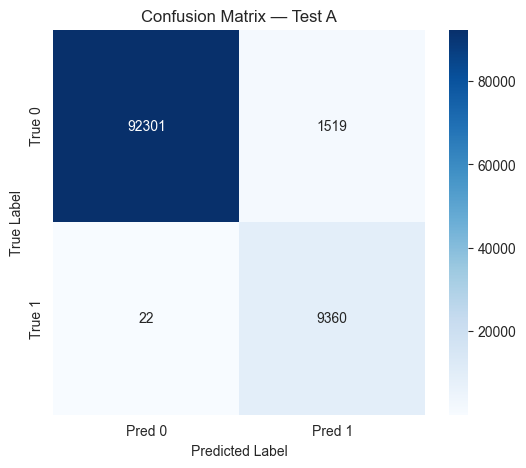

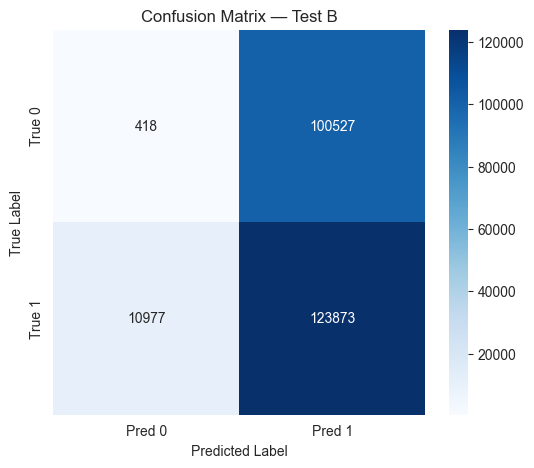

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# ---- Test A ----
plot_confusion_matrix(labelsA, predsA, "Confusion Matrix — Test A")

# ---- Test B ----
plot_confusion_matrix(labelsB, predsB, "Confusion Matrix — Test B")


In [ ]:
class CNN_LSTM_URL_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, lstm_hidden=128, num_filters=128, kernel_size=5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.cnn = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )

        self.lstm = nn.LSTM(
            input_size=num_filters,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(lstm_hidden * 2, 1)

    def forward(self, x):
        x = self.embedding(x)                # (B, L, E)
        x = x.permute(0, 2, 1)               # (B, E, L)

        x = self.cnn(x)                      # (B, C, L)
        x = x.permute(0, 2, 1)               # (B, L, C)

        x, _ = self.lstm(x)                  # (B, L, 2H)
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x
